# Histopathologic Cancer Detection - Competition

This is an attempt at the Histopathologic Cancer Detection Competition for my Deep Learning course - Week 3.  The github repo for this notebook is at https://github.com/chandlerben/ideal-spoon-humbug/

### References

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://www.projectpro.io/recipes/get-all-possible-gpu-tpu-tensorflow

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
import cv2
from PIL import Image

from skimage.transform import rotate
from skimage import io
import cv2 as cv

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

2024-03-03 18:45:33.074092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 18:45:33.074265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 18:45:33.276295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Background, Import, & EDA

This is where the data is going to be pulled in and then I will do the EDA and any cleansing that needs to occur. 

The following description is given on the competition site:

>In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.'

>The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

The goal of this work is to create a model that will be able to accurately detect histopathologic cancer.  This would provide another avenue of diagnosis that can either work in tandem with doctors or flag issues that they could verify.  This would allow for better care and ensure proper treatment. 

In [2]:
#import data

test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# set random state so that all results are reproducible. 
random_number_setting = 16235

The dataset is comprised of .tif files, with each file containing images of size 96x96x3 (Length x Width x Channel), where each pixel value ranges from 0 to 255. Our training dataset includes 220,025 labeled images, denoted as either 1 or 0, where 1 signifies the presence of a cancerous cell.

The dataset consists of numerous small images, each sized 96x96 pixels with 3 channels, accompanied by labels and unique identifiers. We are provided with two datasets already partitioned: a training set with 220,025 distinct images and a test set with approximately 57,500 images. Additionally, there's an identifying dataframe containing 'id' (the unique image ID corresponding to the training directory) and 'label' (indicating the classification category), where labels are binary (0 for non-cancerous, 1 for cancerous).

According to the competition guidelines, if any pixel in an image is identified as cancerous, the entire image is labeled as 1; otherwise, it's labeled as 0. Some of the preprocessing has already been completed for us.

In [3]:
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


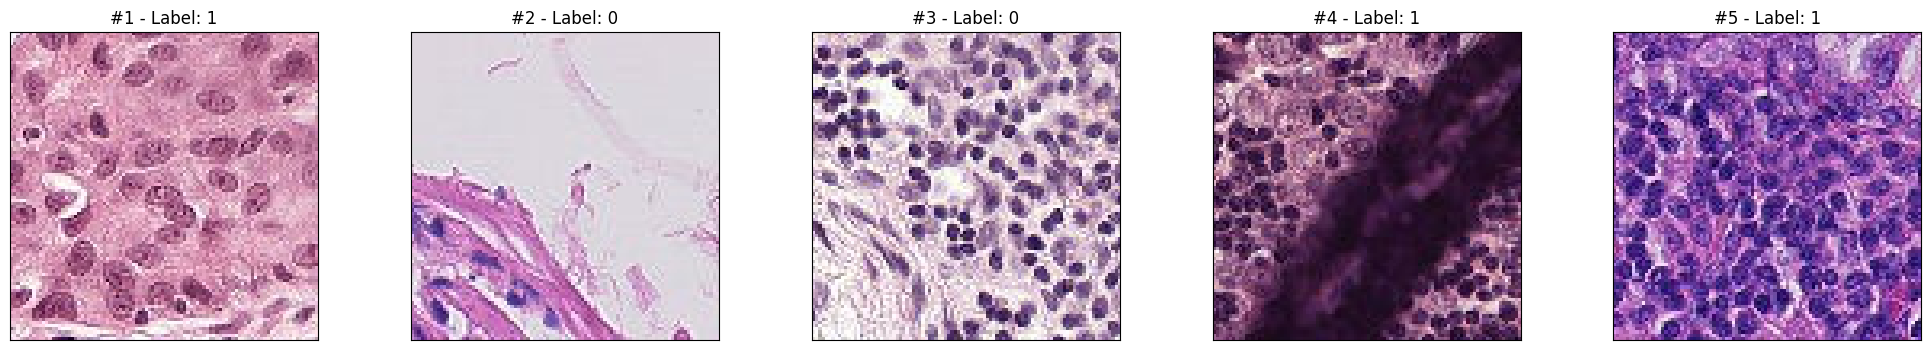

In [6]:
# Let's look at the first 5 images so that we know what we are working with.

img_train = os.listdir(train_path)
img_test = os.listdir(test_path)

fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train_path + img_train[i])
    plt.imshow(im)
    label = train_data.loc[train_data['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

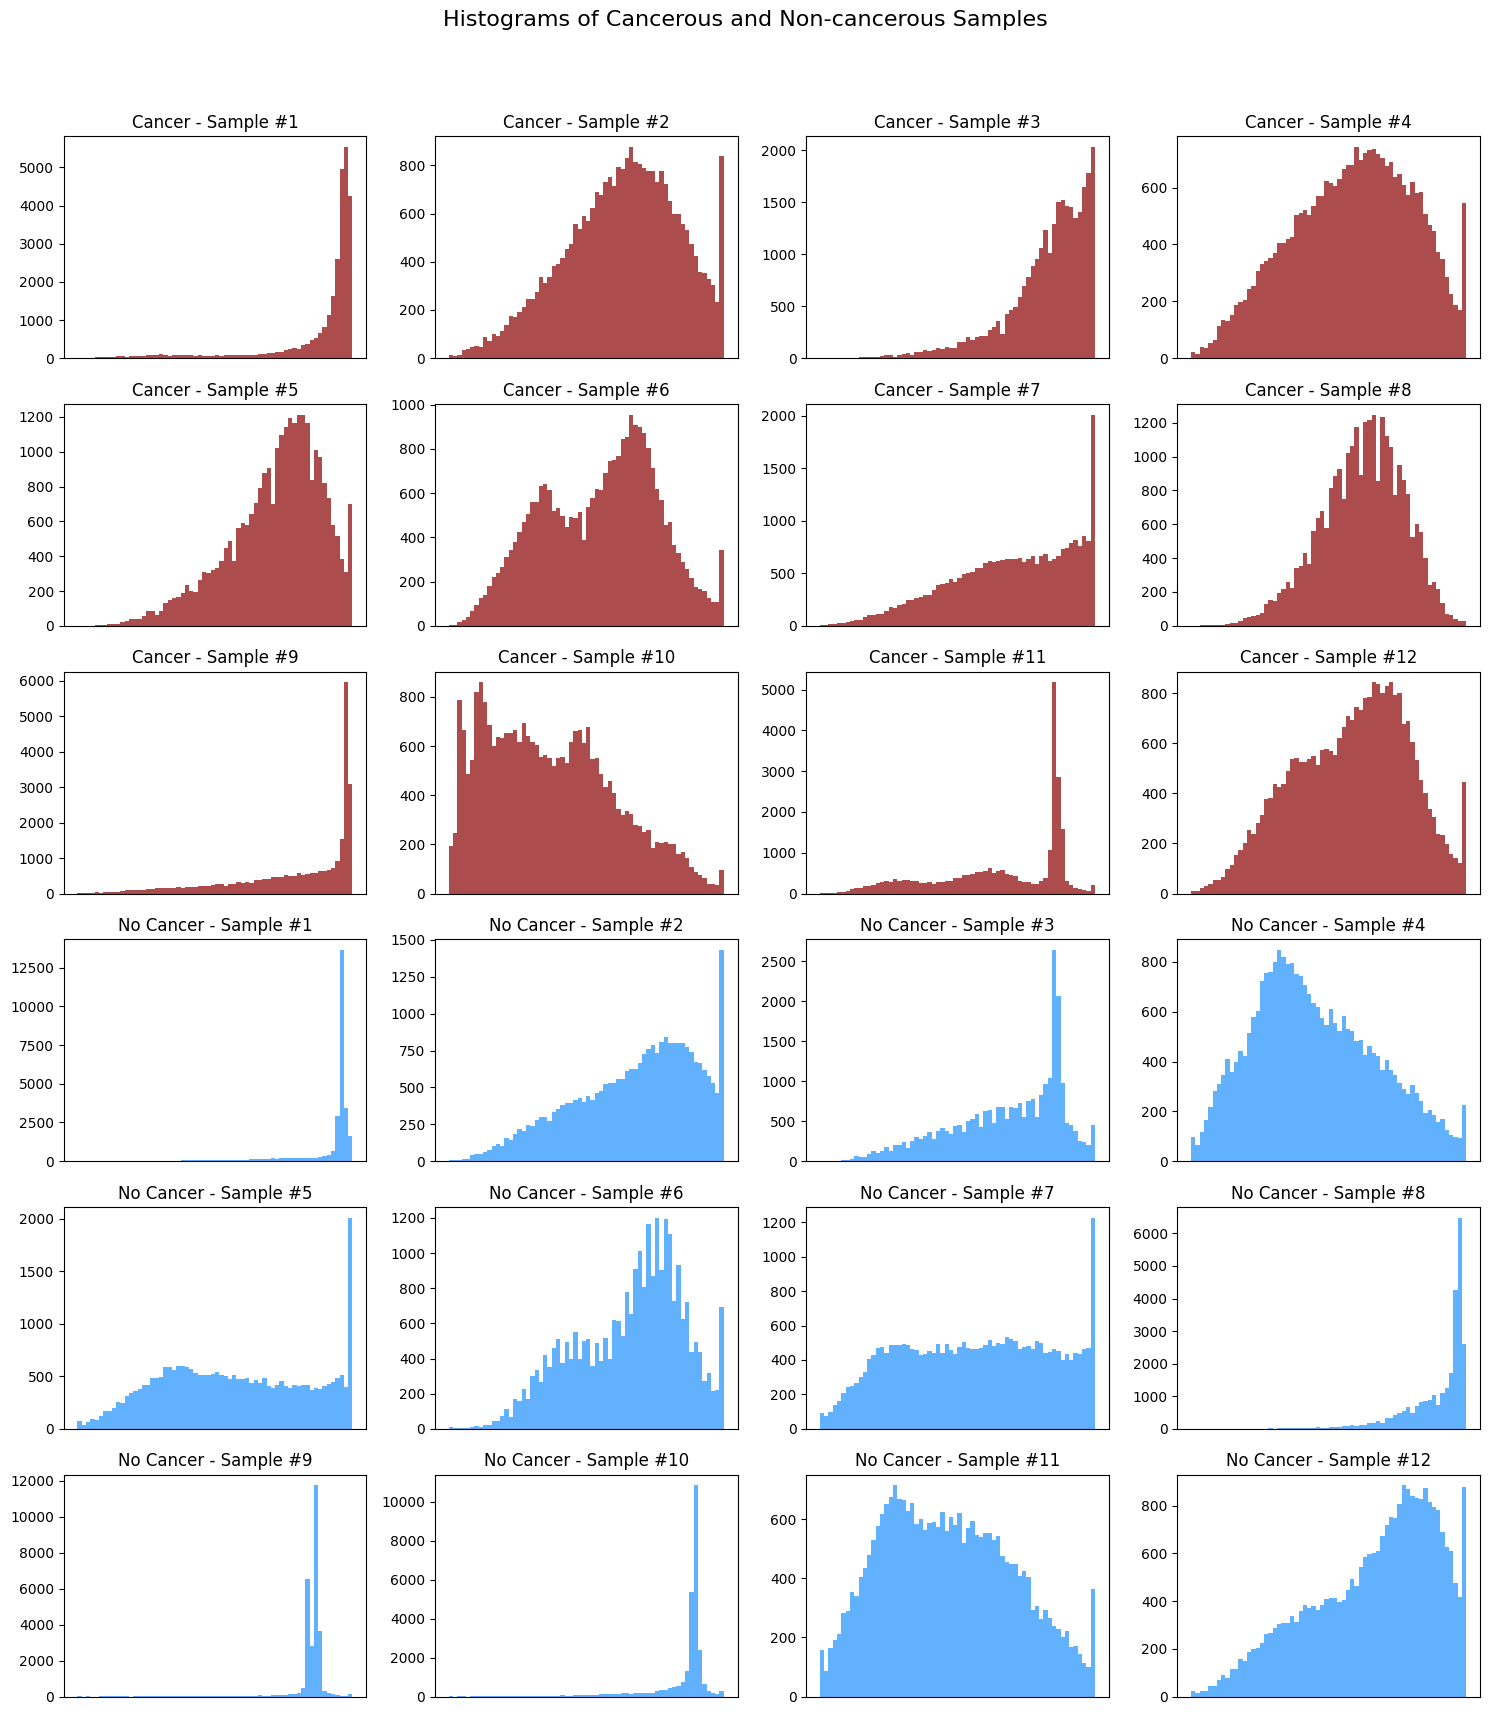

In [7]:
#Explore the differences in the data of cancerous vs non-cancerous images

cancer_samples = train_data[train_data['label'] == 1].head(12)
no_cancer_samples = train_data[train_data['label'] == 0].head(12)

plt.figure(figsize=(15, 18))

for i in range(12):
    plt.subplot(6, 4, i + 1)
    cancer_img = cv2.imread(train_path + cancer_samples.iloc[i]['id'] + '.tif')
    plt.hist(cancer_img.ravel(), bins=64, color='darkred', alpha=0.7)
    plt.title(f'Cancer - Sample #{i+1}')
    plt.xticks([])  # Hide x-axis ticks
    
    plt.subplot(6, 4, i + 13)
    no_cancer_img = cv2.imread(train_path + no_cancer_samples.iloc[i]['id'] + '.tif')
    plt.hist(no_cancer_img.ravel(), bins=64, color='dodgerblue', alpha=0.7)
    plt.title(f'No Cancer - Sample #{i+1}')
    plt.xticks([])  # Hide x-axis ticks

plt.suptitle('Histograms of Cancerous and Non-cancerous Samples', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

       Label Counts
label              
0            130908
1             89117


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


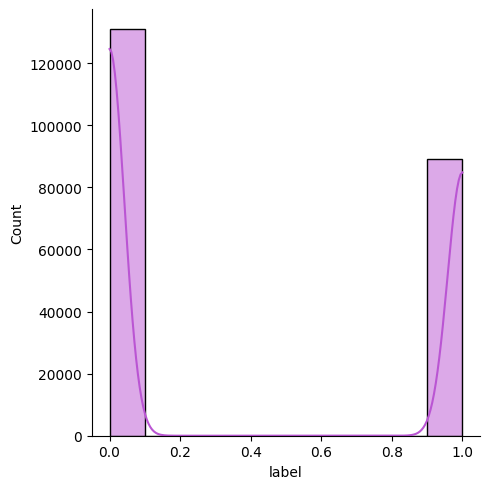

In [8]:
# To explore the data on a large scale, let's see how much of each label exists in the training data.

label_counts = train_data['label'].value_counts()
print(pd.DataFrame(data={'Label Counts': label_counts}))

sns.displot(train_data['label'], kde=True, color='mediumorchid', bins=10)

In handling the training data, our initial step involves addressing any missing values. Following our examination of the source description and data, it is evident that the training set contains no missing data. Additionally, the area of interest within the image is specified as the central pixels (indicated by the red box). Currently, the images are structured as 96x96x3, with the "3" representing the RGB channels. For the present, we will maintain this configuration.

Furthermore, while numerous image augmentations could potentially enhance results and aid in model learning, we will refrain from implementing them initially to maintain simplicity.

Regarding the image data manipulation, we will shuffle the data to prevent the model from learning based on any inherent ordering or patterns within the input images, which could adversely affect the training process. Additionally, we will partition the data into training and validation sets to facilitate model development. Throughout the training phase, we will normalize the pixel values by dividing them by 255.0. This normalization process is expected to optimize data processing and aid in effective model training.

## Model Creation

For this particular model, we will utilize the Keras library to execute a convolutional neural network. Initially, we will run the first model without adjusting any hyperparameters, establishing it as our baseline. Subsequently, we will proceed with a second model, where we will fine-tune our hyperparameters.

To start out, we will normalize the images and then use a sigmoid activation function on the outer layer.  This is a good step as we are working with binary data. The sigmoid function squashes the output values between 0 and 1, which is suitable for binary classification tasks where the output can be interpreted as the probability of belonging to one of the two classes.




3. **Dropout** : we will set dropout at 0.1 which will randonly select some weights and set them to equal 0 which regularizes the model because it is using a smaller number of weights for each training run. 
4. **Optimization** : we will use adaptive moment estimation (Adam) for optimizing the model which essentially mimics momentum for gradient adn gradient-squared. 
5. **Learning rate**: we will set our learning rate to 0.0001 which will assist in the gradient descent such that as the model learns, the speed of learning decreases so that it is less likely to overstep the (hopefully) global minimum. 
6. **Hidden layer activations**: we will use rectified linear regression (ReLU) as our hidden layer activation function which will help the model to converge better, prevent saturation, and provide less need for computation power. 


In [9]:
# set model constants
group_size = 128

In [10]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=random_number_setting)

In [11]:
# This is where the data is normalized and split for validation.
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [12]:
# prepare the data for training
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=group_size,
    seed=random_number_setting,
    class_mode="binary",
    target_size=(64,64))

Found 176020 validated image filenames belonging to 2 classes.


In [13]:
# prepare the data for validation
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=group_size,
    seed=random_number_setting,
    class_mode="binary",
    target_size=(64,64))

Found 44005 validated image filenames belonging to 2 classes.


In [14]:
# prepare the data for predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [15]:
# prepare test data (in same way as train data)
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),   
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [16]:
# setup GPU accelerator - configure Strategy. This will help the code run as quickly as possible.  
# https://www.projectpro.io/recipes/get-all-possible-gpu-tpu-tensorflow

tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

## First Model

The first model is going to be very straight forward and simple.  Just a few layers, with the last layer being the only one that is activated with a sigmoid function.  This is going to be the base step for improving the model.

In [17]:
ROC_1 = tf.keras.metrics.AUC()
with strategy.scope():
    
    base_model = Sequential()
    base_model.add(Conv2D(filters=16, kernel_size=(3,3)))
    base_model.add(Conv2D(filters=16, kernel_size=(3,3)))
    base_model.add(MaxPooling2D(pool_size=(2,2)))
    base_model.add(Conv2D(filters=32, kernel_size=(3,3)))
    base_model.add(Conv2D(filters=32, kernel_size=(3,3)))
    base_model.add(AveragePooling2D(pool_size=(2,2)))
    base_model.add(Flatten())
    base_model.add(Dense(1, activation='sigmoid'))
    base_model.build(input_shape=(group_size, 64, 64, 3))        # original image = (96, 96, 3) 
    base_model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (128, 62, 62, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (128, 60, 60, 16)      │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (128, 30, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (128, 28, 28, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (128, 26, 26, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (128, 13, 13, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (128, 5408)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 1)               │         5,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065 (86.19 KB)

 Trainable params: 22,065 (86.19 KB)

 Non-trainable params: 0 (0.00 B)

Now that the model is built, we will fit it with 10 epochs. 

In [18]:
first_model = base_model.fit(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1566s 1s/step - accuracy: 0.6749 - auc: 0.7068 - loss: 0.6330 - val_accuracy: 0.7640 - val_auc: 0.8252 - val_loss: 0.5156
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1083s 771ms/step - accuracy: 0.7549 - auc: 0.8152 - loss: 0.5200 - val_accuracy: 0.7809 - val_auc: 0.8511 - val_loss: 0.4801
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 940s 655ms/step - accuracy: 0.7731 - auc: 0.8385 - loss: 0.4902 - val_accuracy: 0.7946 - val_auc: 0.8618 - val_loss: 0.4575
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 786s 556ms/step - accuracy: 0.7840 - auc: 0.8502 - loss: 0.4726 - val_accuracy: 0.7649 - val_auc: 0.8660 - val_loss: 0.4873
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 797s 553ms/step - accuracy: 0.7903 - auc: 0.8575 - loss: 0.4622 - val_accuracy: 0.7472 - val_auc: 0.8698 - val_loss: 0.5704
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 808s 558ms/step - accuracy: 0.7940 - auc: 0.8629 - loss: 0.4547 - val_accuracy: 0.8029 - val_auc: 0.8736 - val_loss: 0.4402
Epoch 7/10
1376/

Let's plot how the model performed in terms of loss and accuracy.

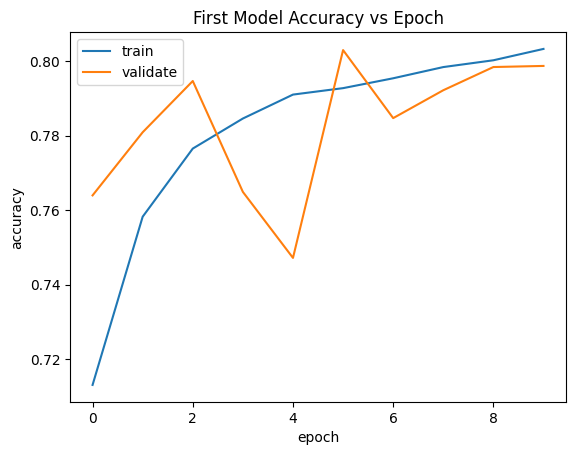

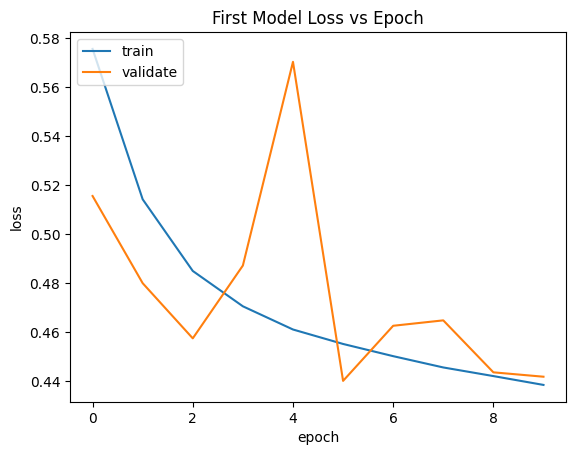

In [19]:
# plot model accuracy per epoch 
plt.plot(first_model.history['accuracy'])
plt.plot(first_model.history['val_accuracy'])
plt.title('First Model Accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(first_model.history['loss'])
plt.plot(first_model.history['val_loss'])
plt.title('First Model Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();



## Second Model

Now that we have a base layer, let's add some hyperparameter tuning.  We will use ReLU activation functions for batch normalization, dropout between clusters and hidden layers.  Then we can flatten and optimize with Adam optimizer

Our second model incorporates hyperparameter tuning. We can see we are using ReLU activation functions for hidden layers, dropout between clusters, and batch normalization. In addition, we have added another hidden layer before the flatten and output layers. Lastly, we are using Adaptive Moment Estimation (Adam) to optimize, helping to accelerate convergence and improve performance.

In [20]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    complex_model = Sequential()
    complex_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    complex_model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    complex_model.add(MaxPooling2D(pool_size=(2,2)))
    complex_model.add(Dropout(0.1))
    complex_model.add(BatchNormalization())
    complex_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    complex_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    complex_model.add(AveragePooling2D(pool_size=(2,2)))
    complex_model.add(Dropout(0.1))
    complex_model.add(BatchNormalization())
    complex_model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    complex_model.add(Flatten())
    complex_model.add(Dense(1, activation='sigmoid'))
    complex_model.build(input_shape=(group_size, 64, 64, 3))       # original image = (96, 96, 3) 
    adam_optimizer = Adam(learning_rate=0.0001)
    complex_model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

complex_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (128, 62, 62, 16)      │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (128, 60, 60, 16)      │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (128, 30, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 30, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (128, 30, 30, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (128, 28, 28, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (128, 26, 26, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (128, 13, 13, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (128, 13, 13, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (128, 13, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (128, 11, 11, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (128, 3872)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 1)               │         3,873 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,969 (117.07 KB)

 Trainable params: 29,873 (116.69 KB)

 Non-trainable params: 96 (384.00 B)

Now that the model is built, we will fit it with 10 epochs. Ideally, I would like to do more but am limited by the GPU limits of Kaggle.

In [21]:
EPOCHS = 10

second_model = complex_model.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 832s 600ms/step - accuracy: 0.7640 - auc_1: 0.8296 - loss: 0.4917 - val_accuracy: 0.7970 - val_auc_1: 0.8860 - val_loss: 0.4742
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 882s 615ms/step - accuracy: 0.8244 - auc_1: 0.8941 - loss: 0.4001 - val_accuracy: 0.8292 - val_auc_1: 0.9072 - val_loss: 0.4088
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 869s 620ms/step - accuracy: 0.8405 - auc_1: 0.9097 - loss: 0.3720 - val_accuracy: 0.8262 - val_auc_1: 0.9160 - val_loss: 0.4335
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 831s 597ms/step - accuracy: 0.8532 - auc_1: 0.9235 - loss: 0.3438 - val_accuracy: 0.8709 - val_auc_1: 0.9368 - val_loss: 0.3187
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 823s 597ms/step - accuracy: 0.8630 - auc_1: 0.9331 - loss: 0.3228 - val_accuracy: 0.8374 - val_auc_1: 0.8818 - val_loss: 0.4495
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 828s 600ms/step - accuracy: 0.8691 - auc_1: 0.9383 - loss: 0.3103 - val_accuracy: 0.8519 - val_auc_1: 0.9392

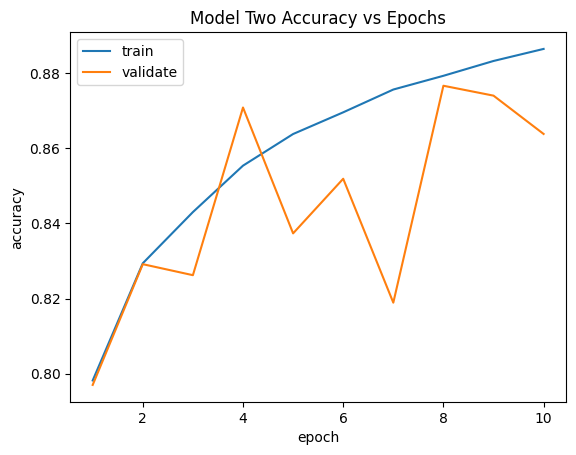

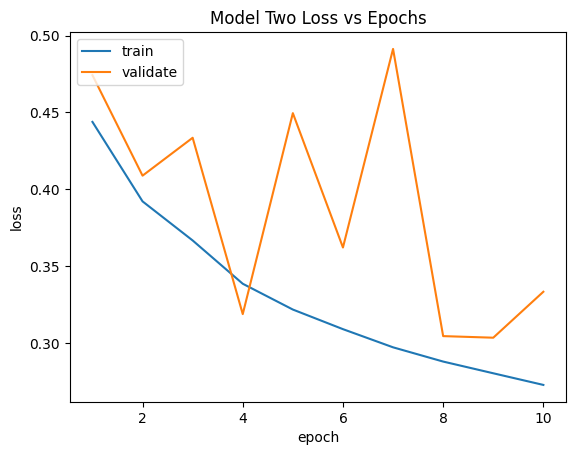

In [22]:
plt.plot(np.arange(1,len(second_model.history['accuracy']) + 1), second_model.history['accuracy'])
plt.plot(np.arange(1,len(second_model.history['val_accuracy']) + 1),second_model.history['val_accuracy'])
plt.title('Model Two Accuracy vs Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(np.arange(1,len(second_model.history['loss']) + 1),second_model.history['loss'])
plt.plot(np.arange(1,len(second_model.history['val_loss']) + 1),second_model.history['val_loss'])
plt.title('Model Two Loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();



In [23]:
#run model to find predictions

predictions = complex_model.predict(test_generator, verbose=1)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 504s 9ms/step


In [24]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [25]:
#view test prediction counts
submission_df['label'].value_counts()

label
0    33069
1    24389
Name: count, dtype: int64

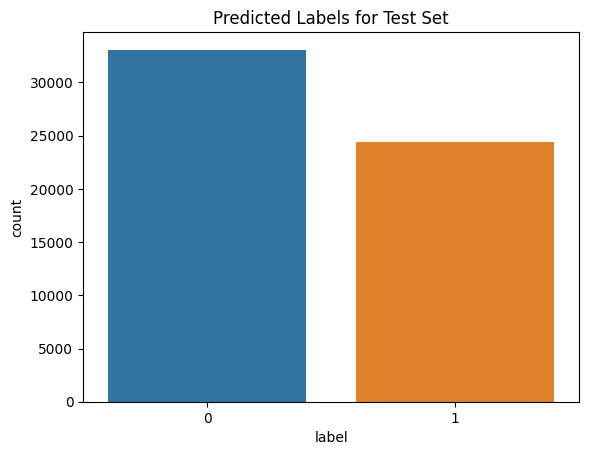

In [26]:
#plot test predictions
sns.countplot(data=submission_df, x='label').set(title='Predicted Labels for Test Set');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


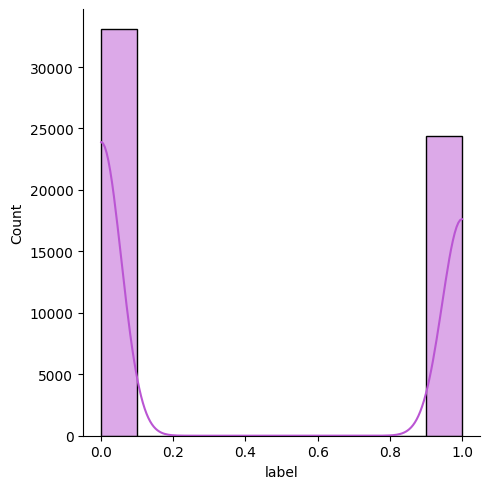

In [27]:
sns.displot(submission_df['label'], kde=True, color='mediumorchid', bins=10)

# Results and Analysis

The initial plot depicts the conventional CNN architecture. We observe a decline in training loss with increasing epoch numbers, which aligns with our expectations. Although the validation loss appears more fluctuating, it generally diminishes as epoch numbers rise. As previously noted, there's potential for improvement if we extend the number of epochs. However, due to time constraints imposed by Kaggle's GPU usage limit, we need to moderate our approach for this project.

The second architecture exhibits notably superior outcomes. Even after just one epoch, there's a marked difference in training loss, indicating the effectiveness of the dense network architecture. This trend persists with higher epochs, consistently yielding smaller loss values. The improved performance is likely attributed to the dense network's ability to capture more intricate patterns within the dataset compared to the traditional CNN structure. Moreover, the fact that the dense network is pretrained provides an initial advantage and expedites optimization.


# Conclusion

The dense network outperformed the CNN network due to its ability to capture more intricate features within our images. However, both models demonstrated proficiency on the training data. Evaluating the dense network's performance on the test data revealed an exceptionally high final score.

Working with neural networks necessitates a distinct approach compared to simpler supervised learning methods like regression analysis. Obtaining results from model training can entail several hours. Therefore, maintaining clean and precise code is crucial to minimize the need for numerous training iterations. An often underestimated aspect that proved invaluable during this project is the strategic use of print statements in the code. This allows for better debugging, inspection of intermediate results, and easier error identification. Additionally, handling image data requires distinct preprocessing techniques compared to textual data. Techniques such as image augmentation can significantly enhance model performance when implemented correctly.

### Possible improvements

An avenue for potential enhancement could involve incorporating the entire image dataset rather than a subset, addressing memory constraints. Additionally, increasing the number of epochs could potentially boost model performance. Exploring the impact of utilizing a balanced image dataset versus the original unbalanced one could also yield valuable insights. With sufficient computational resources, we could broaden our hyperparameter tuning efforts by including additional parameters and expanding the range of values under consideration.